In [1]:
# PARAMS:
BC24H_FILENAME = './data_clean/btc_usd_24h_bitstamp.csv'
BC5M_FILENAME = './data_clean/btc.300s.cbpro.csv'

In [2]:
# autoreload
%load_ext autoreload
%autoreload 1
# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image

%matplotlib inline

Using TensorFlow backend.


In [4]:
%aimport lib.helpers
%aimport lib.etl
%aimport lib.visualization
%aimport lib.walk_forward_predict
%aimport models.rnn
%aimport models.lr
from lib.helpers import (
    timing, print_shapes, fix_all_rngs,
    date_str_to_ts, ymd_to_ts
)
from lib.visualization import simple_plot
from lib.walk_forward_predict import (
    run_walk_forward_validation_rnn,
    run_walk_forward_validation_arima,
    run_walk_forward_validation_rnn_retraining
)
import lib.etl as etl
from models.rnn import make_rnn_model_constructor
from models.lr import LRModel

> size: 387948


datetime    datetime64[ns]
low                float64
high               float64
open               float64
close              float64
volume             float64
dtype: object

,datetime,low,high,open,close,volume
timestamp,,,,,,
1422745200,2015-01-31 23:00:00,224.51,225.69,225.38,224.51,29.638700
1422745500,2015-01-31 23:05:00,224.00,225.59,224.62,224.00,52.189176
1422745800,2015-01-31 23:10:00,221.99,223.92,223.91,221.99,40.262566
1422746100,2015-01-31 23:15:00,218.00,222.00,222.00,218.00,163.490760
1422746400,2015-01-31 23:20:00,217.11,218.89,217.92,218.22,96.317898


,datetime,low,high,open,close,volume
timestamp,,,,,,
1539128100,2018-10-09 23:35:00,6590.30,6593.48,6591.54,6590.30,17.148190
1539128400,2018-10-09 23:40:00,6586.55,6590.31,6590.31,6589.30,15.269094
1539128700,2018-10-09 23:45:00,6589.29,6589.69,6589.30,6589.48,12.466310
1539129000,2018-10-09 23:50:00,6589.47,6592.81,6589.48,6591.85,14.972801
1539129300,2018-10-09 23:55:00,6589.47,6592.81,6591.84,6589.48,31.305392


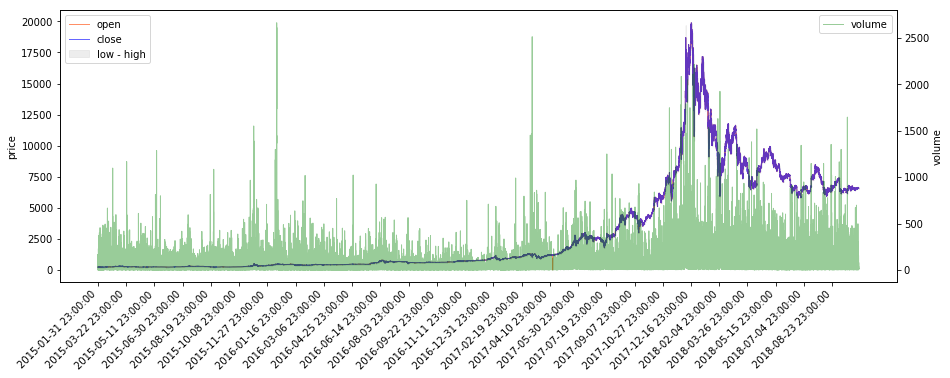

In [5]:
data5m = pd.read_csv(
    BC5M_FILENAME,
    index_col='timestamp',
    parse_dates=['datetime']
)
print('> size:', len(data5m))
dd(data5m.dtypes)
dd(data5m.head())
dd(data5m.tail())
simple_plot(data5m, xticks_span=30 * 24 * 60 // 3)

> size: 1351


close      float64
open       float64
high       float64
low        float64
volume     float64
missing      int64
dtype: object

,close,open,high,low,volume,missing
datetime,,,,,,
2015-02-01,214.8,218.0,220.8,208.5,6.19,0
2015-02-02,238.0,214.8,242.0,214.8,6.42,0
2015-02-03,227.4,238.0,244.4,223.8,17.76,0
2015-02-04,227.0,227.4,231.0,220.0,14.31,0
2015-02-05,217.0,227.0,228.9,213.6,4.31,0


,close,open,high,low,volume,missing
datetime,,,,,,
2018-10-09,6588.8,6604.8,6623.1,6553.1,2.25,0
2018-10-10,6517.5,6588.7,6589.8,6400.0,5.18,0
2018-10-11,6161.0,6517.5,6518.4,6067.0,9.62,0
2018-10-12,6184.9,6152.8,6238.3,6109.8,3.25,0
2018-10-13,6195.0,6180.8,6214.1,6168.8,2.27,0


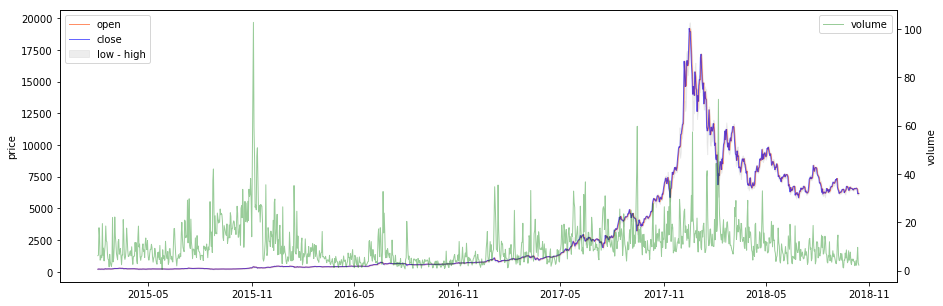

In [6]:
data24h = pd.read_csv(
    BC24H_FILENAME,
    index_col='datetime',
    parse_dates=['datetime']
)
print('> size:', len(data24h))
dd(data24h.dtypes)
dd(data24h.head())
dd(data24h.tail())
simple_plot(data24h, show_xlabels=False)

In [11]:
%matplotlib qt

In [8]:
%matplotlib inline

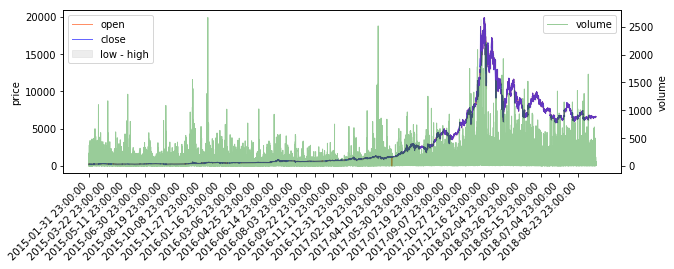

In [9]:
simple_plot(data5m, xticks_span=30 * 24 * 60 // 3)

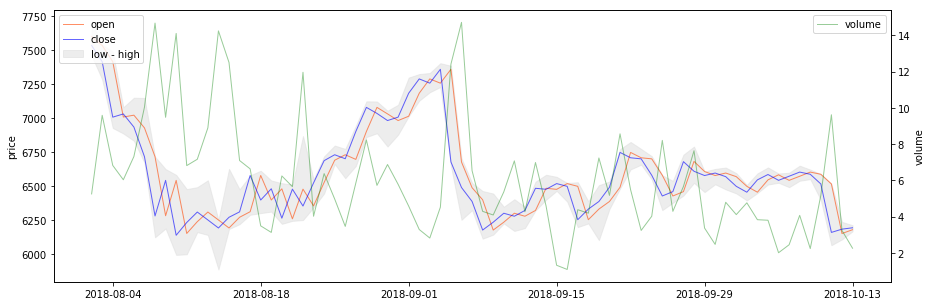

In [14]:
simple_plot(data24h[data24h.index > helpers.ym '2018-08-01'], show_xlabels=False)

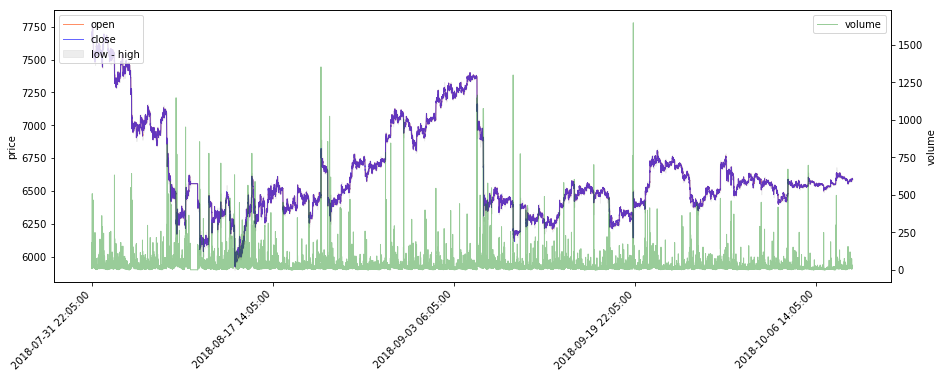

In [19]:
simple_plot(data5m[data5m.index > ymd_to_ts(2018, 8, 1)], xticks_span=10 * 24 * 60 // 3)

In [20]:
import plotly
plotly.tools.set_credentials_file(username='', api_key='')

In [21]:
import plotly.plotly as py
import plotly.graph_objs as go

In [27]:
# trace = go.Candlestick(
#     x=data24h.index,
#     open=data24h.open,
#     high=data24h.high,
#     low=data24h.low,
#     close=data24h.close,
#     increasing=dict(fillcolor='#FFFFFF'))
# data = [trace]
# py.iplot(data, filename='simple_candlestick')

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [12]:
dec = seasonal_decompose(
    data5m['close'].values,
    freq=365 * 24 * 60 // 5  # yearly
)
xs = data5m['datetime'].values
plt.figure()
plt.plot(xs, data5m['close'].values, color='b', label='Closing Price')
plt.plot(xs, dec.trend, color='green', label='Trend')
plt.plot(xs, dec.seasonal, color='orange', label='Seasonal')
plt.plot(xs, dec.resid, color='red', label='Residual')
plt.legend()
plt.show()